## Warsztaty Badawcze XIC
### PD 1
#### Adrian Kamiński

### Import libraries

In [1]:
import numpy as np

import torch
import torchvision

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import f1_score

torch.manual_seed(2606)
np.random.seed(2606)

###  Prepare data

In [2]:
# xor

In [3]:
x_xor = np.random.uniform(-4, 4, (200, 2)) # generate data
y_xor = np.apply_along_axis(lambda x: [0, 1] if np.prod(x) > 0 else [1, 0], 1, x_xor) # assign classes

In [4]:
x_xor_train, x_xor_test, y_xor_train, y_xor_test = train_test_split(x_xor, y_xor,
                                                                    test_size=0.2, stratify=y_xor, 
                                                                    random_state=42)

In [5]:
x_xor_train_t = torch.from_numpy(x_xor_train).type(torch.float32)
x_xor_test_t = torch.from_numpy(x_xor_test).type(torch.float32)
    
y_xor_train_t = torch.from_numpy(y_xor_train).type(torch.float32)
y_xor_test_t = torch.from_numpy(y_xor_test).type(torch.float32)

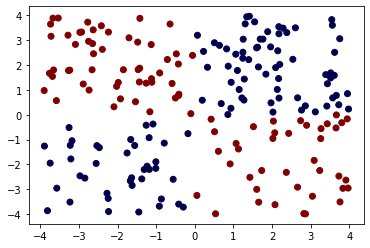

In [6]:
plt.scatter(x_xor[:,0], x_xor[:,1], c=y_xor[:,0], cmap=plt.get_cmap('seismic'))
plt.show()

In [7]:
# iris

In [8]:
x_iris, y_iris = load_iris(return_X_y=True)

In [9]:
#ohc
y_iris = np.array([[1,0,0] if y==0 else [0,1,0] if y==1 else [0,0,1] for y in y_iris])

In [10]:
x_iris_train, x_iris_test, y_iris_train, y_iris_test = train_test_split(x_iris, y_iris, 
                                                                        test_size=0.2, stratify=y_iris, 
                                                                        random_state=42)

In [11]:
x_iris_train_t = torch.from_numpy(x_iris_train).type(torch.float32)
x_iris_test_t = torch.from_numpy(x_iris_test).type(torch.float32)
    
y_iris_train_t = torch.from_numpy(y_iris_train).type(torch.float32)
y_iris_test_t = torch.from_numpy(y_iris_test).type(torch.float32)

In [12]:
x_iris.shape

(150, 4)

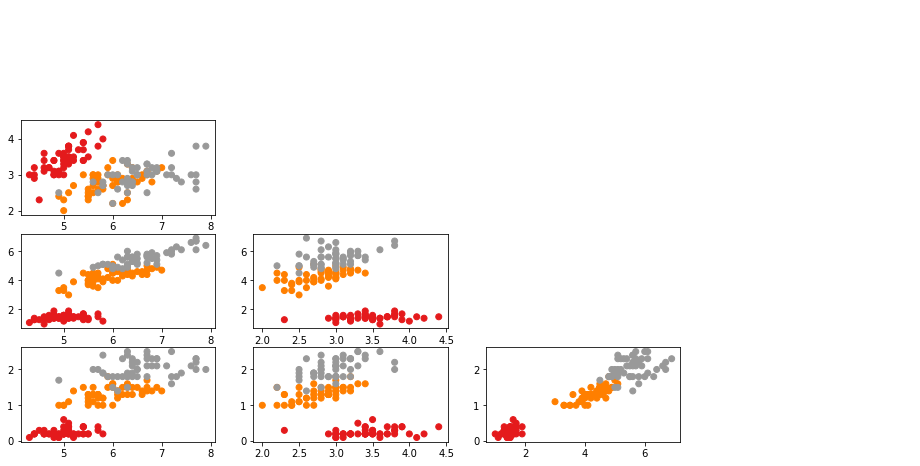

In [13]:
fig, axs = plt.subplots(4, 4, sharex=False, sharey=False, figsize=(16, 8))


for i in range(x_iris.shape[1]):
    for j in range(x_iris.shape[1]):
        if i>=j:
            axs[j][i].axis('off')
        else:
            axs[j][i].scatter(x_iris[:,i], x_iris[:,j], c=y_iris.argmax(1), cmap=plt.get_cmap('Set1'))

plt.show()

Ten znany zbiór powiniem być łatwy do nauczenia, widzimy że klasy są liniowo seperowalne.

### Tworzenie pierwszych modeli

In [14]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true.numpy()).sum() / y_pred.size

In [15]:
def round_array(array):
    idx = np.argmax(array, axis=1)
    array = np.zeros( array.shape )
    array[ np.arange(array.shape[0]), idx] = 1
    return array

In [16]:
def create_model(*layers):
    return torch.nn.Sequential(*layers)

In [17]:
def init_weights(m, init = torch.nn.init.xavier_normal_):
    if isinstance(m, torch.nn.Linear):
        init(m.weight)

In [18]:
def train(model, X_train_t, y_train_t, X_test_t, y_test_t,
          lr=1e-3, lossFunc = torch.nn.BCELoss,
          error_loss_func = torch.nn.functional.binary_cross_entropy,
          optim = torch.optim.SGD,
          num_iter = 200, batch_size = 64,
          init = torch.nn.init.xavier_normal_
):
    model.apply(lambda m: init_weights(m, init=init))
    loss = lossFunc()
    optimizer = optim(model.parameters(), lr=lr)
    
    losses = []
    errors_train = []
    errors_test = []
    
    for epoch in range(num_iter):
        losses_iter = []
        errors_train_iter = []
        errors_test_iter = []

#         model.eval()
        for batch in range(int(X_train_t.shape[0] / batch_size)):
            X = X_train_t[batch*batch_size:((batch+1)*batch_size),]
            y = y_train_t[batch*batch_size:((batch+1)*batch_size),]
            y_hat = model(X)
            errors_train_iter += [error_loss_func(y, y_hat).item()]

        for batch in range(int(X_test_t.shape[0] / batch_size)):
            X = X_test_t[batch*batch_size:((batch+1)*batch_size),]
            y = y_test_t[batch*batch_size:((batch+1)*batch_size),]
            y_hat = model(X)
            errors_test_iter += [error_loss_func(y, y_hat).item()]

#         model.train()
        for batch in range(int(X_train_t.shape[0] / batch_size)):
            X = X_train_t[batch*batch_size:((batch+1)*batch_size),]
            y = y_train_t[batch*batch_size:((batch+1)*batch_size),]
            y_hat = model(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.mean().backward()
            losses_iter += [l.mean().item()]
            optimizer.step()

        errors_train += [np.mean(errors_train_iter)]
        errors_test += [np.mean(errors_test_iter)]
        losses += [np.mean(losses_iter)]
        
    return losses, errors_train, errors_test

#### Sieci do problemu XOR

1. Pierwsza sieć:
    - architektura sieci `2(input) -> 4(hidden) -> 2(output)`
    - funkcja aktywacji: `ReLU`
    - funkcja na wyjściu: `Softmax`
    - learning rate: `0.05`

In [19]:
model_xor = create_model(
    torch.nn.Linear(2, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 2),
    torch.nn.Softmax(dim=1)
)

In [20]:
losses, errors_train, errors_test = train(
    model_xor, x_xor_train_t, y_xor_train_t, x_xor_test_t, y_xor_test_t,
    lr=0.05, lossFunc = torch.nn.CrossEntropyLoss, # BCELoss MSELoss CrossEntropyLoss
    error_loss_func = torch.nn.functional.cross_entropy, # binary_cross_entropy mse_loss cross_entropy
    optim = torch.optim.SGD,
    num_iter = 500, batch_size = 8,
    init = torch.nn.init.xavier_normal_
)

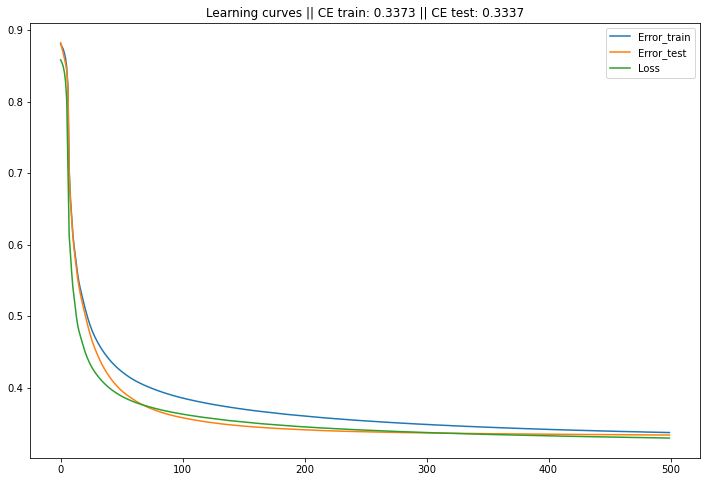

In [21]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(errors_train)), errors_train)
plt.plot(range(len(errors_test)), errors_test)
plt.plot(range(len(losses)), losses)
plt.title(f'Learning curves || CE train: {errors_train[-1]:.4} || CE test: {errors_test[-1]:.4}')
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

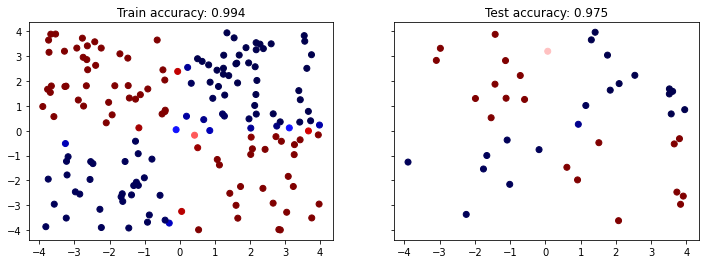

In [22]:
y_pred_train = round_array(model_xor(x_xor_train_t).detach().numpy())
y_pred_test = round_array(model_xor(x_xor_test_t).detach().numpy())

y_pred_train_p = model_xor(x_xor_train_t).detach().numpy()
y_pred_test_p = model_xor(x_xor_test_t).detach().numpy()

fig, axs = plt.subplots(1, 2, sharey='row', figsize=(12, 4))
axs[0].scatter(x_xor_train_t[:,0], x_xor_train_t[:,1], c=y_pred_train_p[:,0], cmap=plt.get_cmap('seismic'))
axs[0].set_title(f'Train accuracy: {accuracy(y_pred_train, y_xor_train_t):.3}')
axs[1].scatter(x_xor_test_t[:,0], x_xor_test_t[:,1], c=y_pred_test_p[:,0], cmap=plt.get_cmap('seismic'))
axs[1].set_title(f'Test accuracy: {accuracy(y_pred_test, y_xor_test_t):.3}')
plt.show()

In [23]:
# biały kolor pstwo ~ 0.5 

1. Druga sieć:
    - architektura sieci `2(input) -> 6(hidden) -> 4(hidden) -> 2(output)`
    - funkcja aktywacji: `ReLU`
    - funkcja na wyjściu: `Softmax`
    - learning rate: `0.05`

In [24]:
model_xor2 = create_model(
    torch.nn.Linear(2, 6),
    torch.nn.ReLU(),
    torch.nn.Linear(6, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 2),
    torch.nn.Softmax(dim=1)
)

In [25]:
losses2, errors_train2, errors_test2 = train(
    model_xor2, x_xor_train_t, y_xor_train_t, x_xor_test_t, y_xor_test_t,
    lr=0.05, lossFunc = torch.nn.CrossEntropyLoss, # BCELoss MSELoss CrossEntropyLoss
    error_loss_func = torch.nn.functional.cross_entropy, # binary_cross_entropy mse_loss cross_entropy
    optim = torch.optim.SGD,
    num_iter = 500, batch_size = 8,
    init = torch.nn.init.xavier_normal_
)

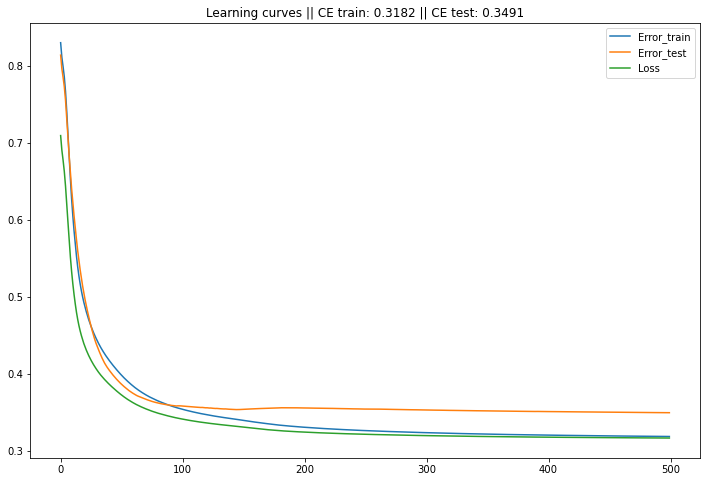

In [26]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(errors_train2)), errors_train2)
plt.plot(range(len(errors_test2)), errors_test2)
plt.plot(range(len(losses2)), losses2)
plt.title(f'Learning curves || CE train: {errors_train2[-1]:.4} || CE test: {errors_test2[-1]:.4}')
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

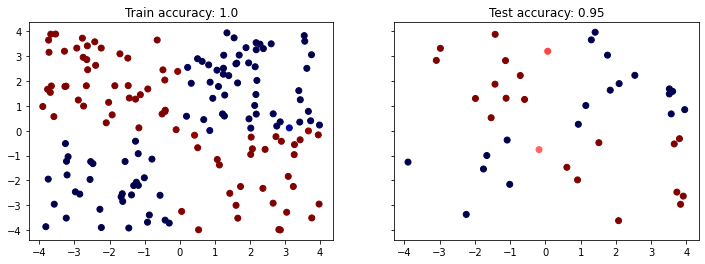

In [27]:
y_pred_train2 = round_array(model_xor2(x_xor_train_t).detach().numpy())
y_pred_test2 = round_array(model_xor2(x_xor_test_t).detach().numpy())

y_pred_train2_p = model_xor2(x_xor_train_t).detach().numpy()
y_pred_test2_p = model_xor2(x_xor_test_t).detach().numpy()

fig, axs = plt.subplots(1, 2, sharey='row', figsize=(12, 4))
axs[0].scatter(x_xor_train_t[:,0], x_xor_train_t[:,1], c=y_pred_train2_p[:,0], cmap=plt.get_cmap('seismic'))
axs[0].set_title(f'Train accuracy: {accuracy(y_pred_train2, y_xor_train_t):.3}')
axs[1].scatter(x_xor_test_t[:,0], x_xor_test_t[:,1], c=y_pred_test2_p[:,0], cmap=plt.get_cmap('seismic'))
axs[1].set_title(f'Test accuracy: {accuracy(y_pred_test2, y_xor_test_t):.3}')
plt.show()

Zwiększenie sieci polepszyło precyzję na zbiorze treningowym, jednak zmniejszyło (niewiele) prezycję na zbiorze testowym.

Najprawdopodobniej spowodowane jest to ilością danych które dostarczyliśmy do zbioru treningowego.

#### Sieci do problemu IRIS

1. Pierwsza sieć:
    - architektura sieci `4(input) -> 3(hidden) -> 3(output)`
    - funkcja aktywacji: `ReLU`
    - funkcja na wyjściu: `Softmax`
    - learning rate: `0.05`

In [28]:
model_iris = create_model(
    torch.nn.Linear(4, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 3),
    torch.nn.Softmax(dim=1)
)

In [29]:
losses_iris, errors_train_iris, errors_test_iris = train(
    model_iris, x_iris_train_t, y_iris_train_t, x_iris_test_t, y_iris_test_t,
    lr=0.05, lossFunc = torch.nn.CrossEntropyLoss, # BCELoss MSELoss CrossEntropyLoss
    error_loss_func = torch.nn.functional.cross_entropy, # binary_cross_entropy mse_loss cross_entropy
    optim = torch.optim.SGD,
    num_iter = 500, batch_size = 8,
    init = torch.nn.init.xavier_normal_
)

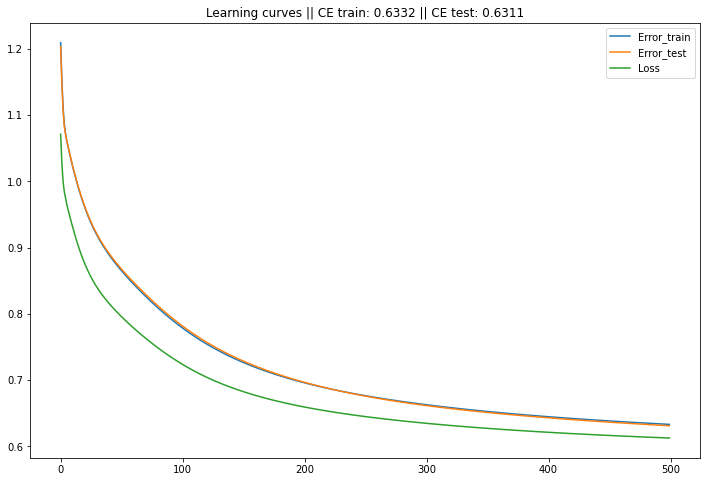

In [30]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(errors_train_iris)), errors_train_iris)
plt.plot(range(len(errors_test_iris)), errors_test_iris)
plt.plot(range(len(losses_iris)), losses_iris)
plt.title(f'Learning curves || CE train: {errors_train_iris[-1]:.4} || CE test: {errors_test_iris[-1]:.4}')
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

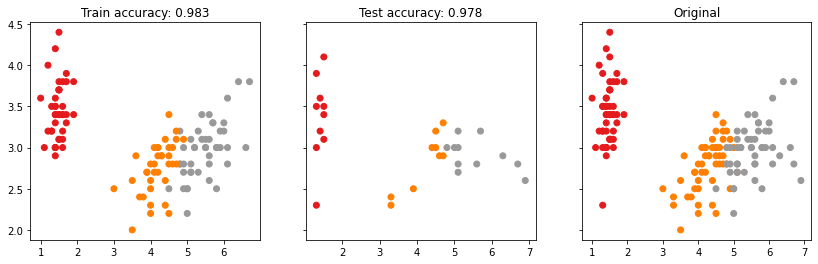

In [31]:
y_pred_iris_train = round_array(model_iris(x_iris_train_t).detach().numpy())
y_pred_iris_test = round_array(model_iris(x_iris_test_t).detach().numpy())

y_pred_iris_train_p = model_iris(x_iris_train_t).detach().numpy()
y_pred_iris_test_p = model_iris(x_iris_test_t).detach().numpy()

fig, axs = plt.subplots(1, 3, sharey='row', figsize=(14, 4))
axs[0].scatter(x_iris_train_t[:,2], x_iris_train_t[:,1], c=y_pred_iris_train_p.argmax(1), cmap=plt.get_cmap('Set1'))
axs[0].set_title(f'Train accuracy: {accuracy(y_pred_iris_train, y_iris_train_t):.3}')

axs[1].scatter(x_iris_test_t[:,2], x_iris_test_t[:,1], c=y_pred_iris_test_p.argmax(1), cmap=plt.get_cmap('Set1'))
axs[1].set_title(f'Test accuracy: {accuracy(y_pred_iris_test, y_iris_test_t):.3}')

axs[2].scatter(x_iris[:,2], x_iris[:,1], c=y_iris.argmax(1), cmap=plt.get_cmap('Set1'))
axs[2].set_title(f'Original')
plt.show()

2. Druga sieć:
    - architektura sieci `4(input) -> 3(hidden) -> 3(hidden) -> 3(output)`
    - funkcja aktywacji: `ReLU`
    - funkcja na wyjściu: `Softmax`
    - learning rate: `0.01`

In [32]:
model_iris2 = create_model(
    torch.nn.Linear(4, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 3),
    torch.nn.ReLU(),
    torch.nn.Linear(3, 3),
    torch.nn.Softmax(dim=1)
)

In [33]:
losses_iris2, errors_train_iris2, errors_test_iris2 = train(
    model_iris2, x_iris_train_t, y_iris_train_t, x_iris_test_t, y_iris_test_t,
    lr=0.01, lossFunc = torch.nn.CrossEntropyLoss, # BCELoss MSELoss CrossEntropyLoss
    error_loss_func = torch.nn.functional.cross_entropy, # binary_cross_entropy mse_loss cross_entropy
    optim = torch.optim.SGD,
    num_iter = 500, batch_size = 8,
    init = torch.nn.init.xavier_normal_
)

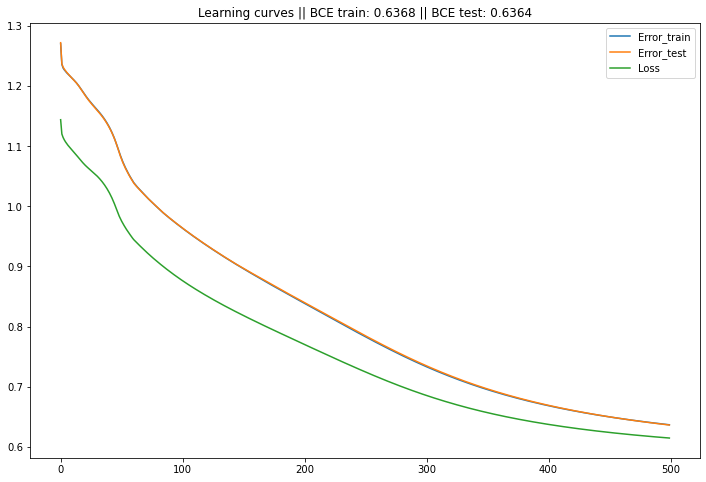

In [34]:
plt.figure(figsize=(12, 8))
plt.plot(range(len(errors_train_iris2)), errors_train_iris2)
plt.plot(range(len(errors_test_iris2)), errors_test_iris2)
plt.plot(range(len(losses_iris2)), losses_iris2)
plt.title(f'Learning curves || BCE train: {errors_train_iris2[-1]:.4} || BCE test: {errors_test_iris2[-1]:.4}')
plt.legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

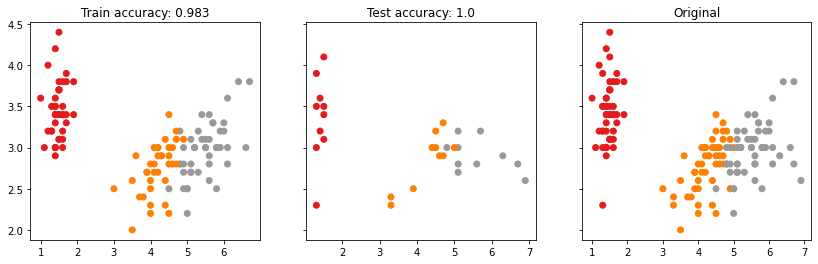

In [35]:
y_pred_iris2_train = round_array(model_iris2(x_iris_train_t).detach().numpy())
y_pred_iris2_test = round_array(model_iris2(x_iris_test_t).detach().numpy())

y_pred_iris2_train_p = model_iris2(x_iris_train_t).detach().numpy()
y_pred_iris2_test_p = model_iris2(x_iris_test_t).detach().numpy()

fig, axs = plt.subplots(1, 3, sharey='row', figsize=(14, 4))
axs[0].scatter(x_iris_train_t[:,2], x_iris_train_t[:,1], c=y_pred_iris2_train_p.argmax(1), cmap=plt.get_cmap('Set1'))
axs[0].set_title(f'Train accuracy: {accuracy(y_pred_iris2_train, y_iris_train_t):.3}')

axs[1].scatter(x_iris_test_t[:,2], x_iris_test_t[:,1], c=y_pred_iris2_test_p.argmax(1), cmap=plt.get_cmap('Set1'))
axs[1].set_title(f'Test accuracy: {accuracy(y_pred_iris2_test, y_iris_test_t):.3}')

axs[2].scatter(x_iris[:,2], x_iris[:,1], c=y_iris.argmax(1), cmap=plt.get_cmap('Set1'))
axs[2].set_title(f'Original')
plt.show()

Otrzymujemy bardzo dobre wyniki (nawet dla małych sieci), ale mogliśmy się tego spodziewać, ponieważ nie jest to zbyt trudna klasyfikacja.

### Analiza wykorzystania różnych wartości learning rate

#### XOR problem

In [36]:
learning_rates = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

In [37]:
all_losses = []
all_errors_train = []
all_errors_test = []
all_accuracy = []
for lr in learning_rates:
    losses, errors_train, errors_test = train(
        model_xor, x_xor_train_t, y_xor_train_t, x_xor_test_t, y_xor_test_t,
        lr=lr, lossFunc = torch.nn.CrossEntropyLoss, # BCELoss MSELoss CrossEntropyLoss
        error_loss_func = torch.nn.functional.cross_entropy, # binary_cross_entropy mse_loss cross_entropy
        optim = torch.optim.SGD,
        num_iter = 500, batch_size = 8,
        init = torch.nn.init.xavier_normal_
    )
    all_losses.append(losses)
    all_errors_train.append(errors_train)
    all_errors_test.append(errors_test)
    
    y_pred_test = round_array(model_xor(x_xor_test_t).detach().numpy())
    
    all_accuracy.append(accuracy(y_pred_test, y_xor_test_t))

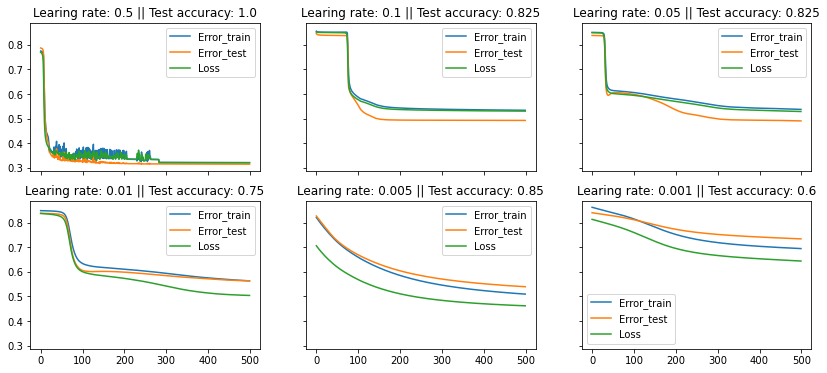

In [38]:
fig, axs = plt.subplots(len(learning_rates) // 3 + len(learning_rates) % 3 , 3, sharey=True, sharex=True, figsize=(14, 6))

for i in range(len(learning_rates)):
    r = 0 if i < 3 else 1
    c = i % 3
    axs[r][c].plot(range(len(all_errors_train[i])), all_errors_train[i])
    axs[r][c].plot(range(len(all_errors_test[i])), all_errors_test[i])
    axs[r][c].plot(range(len(all_losses[i])), all_losses[i])
    axs[r][c].set_title(f'Learing rate: {learning_rates[i]} || Test accuracy: {all_accuracy[i]:.3}')
    axs[r][c].legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

#### Iris problem

In [39]:
learning_rates = [0.5, 0.1, 0.05, 0.01, 0.005, 0.001]

In [40]:
torch.optim.SGD

torch.optim.sgd.SGD

In [41]:
all_losses = []
all_errors_train = []
all_errors_test = []
all_accuracy = []
for lr in learning_rates:
    losses, errors_train, errors_test = train(
        model_iris, x_iris_train_t, y_iris_train_t, x_iris_test_t, y_iris_test_t,
        lr=lr, lossFunc = torch.nn.CrossEntropyLoss, # BCELoss MSELoss CrossEntropyLoss
        error_loss_func = torch.nn.functional.cross_entropy, # binary_cross_entropy mse_loss cross_entropy
        optim = torch.optim.SGD,
        num_iter = 500, batch_size = 8,
        init = torch.nn.init.xavier_normal_
    )
    all_losses.append(losses)
    all_errors_train.append(errors_train)
    all_errors_test.append(errors_test)
    
    y_pred_test = round_array(model_iris(x_iris_test_t).detach().numpy())
    
    all_accuracy.append(accuracy(y_pred_test, y_iris_test_t))

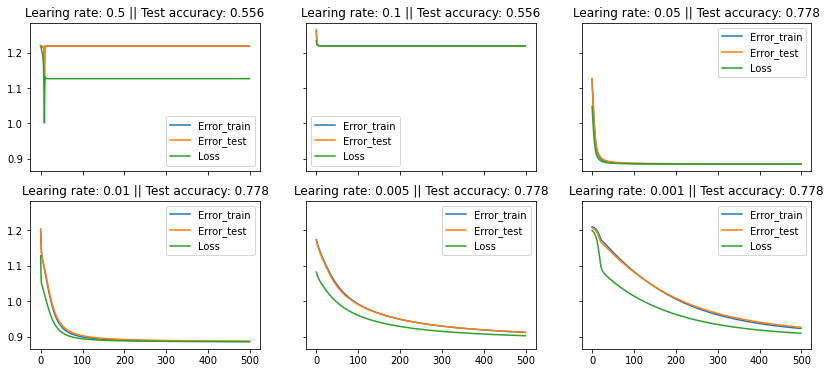

In [42]:
fig, axs = plt.subplots(len(learning_rates) // 3 + len(learning_rates) % 3 , 3, sharey=True, sharex=True, figsize=(14, 6))

for i in range(len(learning_rates)):
    r = 0 if i < 3 else 1
    c = i % 3
    axs[r][c].plot(range(len(all_errors_train[i])), all_errors_train[i])
    axs[r][c].plot(range(len(all_errors_test[i])), all_errors_test[i])
    axs[r][c].plot(range(len(all_losses[i])), all_losses[i])
    axs[r][c].set_title(f'Learing rate: {learning_rates[i]} || Test accuracy: {all_accuracy[i]:.3}')
    axs[r][c].legend(['Error_train', 'Error_test', 'Loss'])
plt.show()

Widzmy, że prawidłowy dobór `learning rate` potrafi zdecydowanie wpłynąć na proces uczenia modelu, jednak dobór ten nie jest czymś łatwym (dla każdego nowego zbioru różne wartości mogą dawać różne efekty).

### MNIST dataset classification

In [43]:
mnist_train = torchvision.datasets.FashionMNIST(
    root="/data", train=True, transform=torchvision.transforms.ToTensor(), download=True
)
mnist_test = torchvision.datasets.FashionMNIST(
    root="/data", train=False, transform=torchvision.transforms.ToTensor(), download=True
)

In [54]:
model_mnist = create_model(
    torch.nn.Flatten(),
    torch.nn.Linear(784, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 10),
    torch.nn.Softmax(dim=1)
)

model_mnist.apply(lambda m: init_weights(m, init=torch.nn.init.xavier_normal_))

learning_rate = 0.03
loss = torch.nn.CrossEntropyLoss(reduction='none')
optimizer = torch.optim.SGD(model_mnist.parameters(), lr=learning_rate)

In [55]:
num_iter = 10
batch_size = 256
dataloader_train = torch.utils.data.DataLoader(mnist_train, batch_size, shuffle=True, num_workers=2)
dataloader_test = torch.utils.data.DataLoader(mnist_test, batch_size, shuffle=True, num_workers=2)

losses = []
errors_train = []
errors_test = []

In [56]:
import tqdm # pip install tqdm
for epoch in tqdm.tqdm(range(num_iter)):
    losses_iter = []
    errors_train_iter = []
    errors_test_iter = []
    
#     model.eval()
    for X, y in dataloader_test:
        y_hat = model_mnist(X)
        errors_test_iter += [(y != y_hat.argmax(1)).float().mean().item()]

    for X, y in dataloader_train:
        y_hat = model_mnist(X)
        errors_train_iter += [(y != y_hat.argmax(1)).float().mean().item()]
        
#     model.train()
    for X, y in dataloader_train:
        y_hat = model_mnist(X)
        l = loss(y_hat, y)
        optimizer.zero_grad()
        l.mean().backward()
        losses_iter += [l.mean().item()]
        optimizer.step()
        
    errors_train += [np.mean(errors_train_iter)]
    errors_test += [np.mean(errors_test_iter)]
    losses += [np.mean(losses_iter)]

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:55<00:00, 11.55s/it]


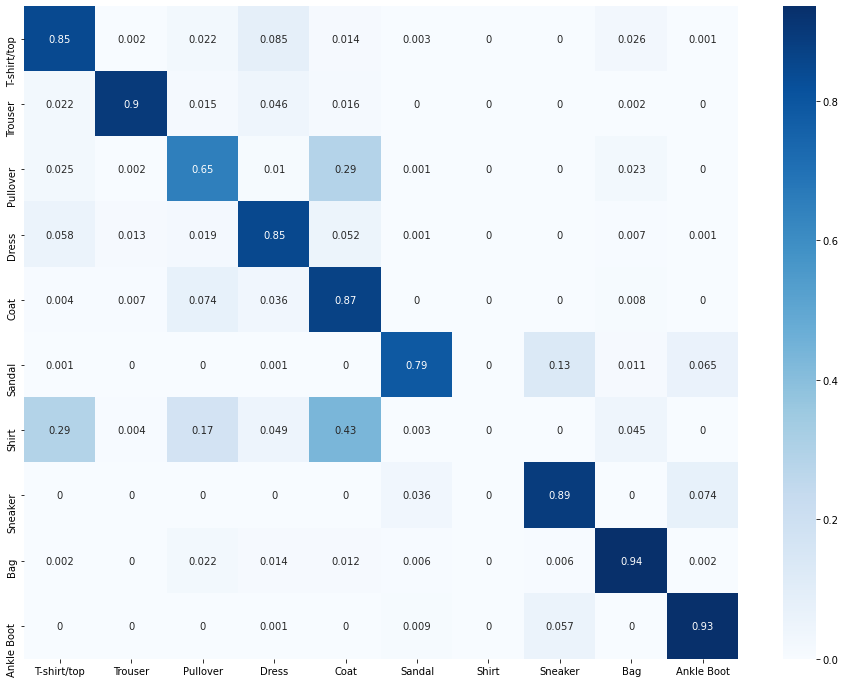

In [57]:
from sklearn.metrics import confusion_matrix

import pandas as pd

y_pred = []
y_true = []

# iterate over test data
for inputs, labels in dataloader_test:
    output = model_mnist(inputs) # Feed Network

    output = (torch.max(output, 1)[1]).data.cpu().numpy()
    y_pred.extend(output) # Save Prediction

    labels = labels.data.cpu().numpy()
    y_true.extend(labels) # Save Truth

# constant for classes
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
        'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle Boot')

# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (16, 12))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()

In [58]:
print(f'Accuracy: {accuracy(np.array(y_pred), torch.FloatTensor(y_true)):.4f}')
print(f"F1 macro: {f1_score(y_true, y_pred, average='macro'):.4f}")

Accuracy: 0.7666
F1 macro: 0.7321


Nasz model jest w miare skuteczny (accuracy 0.77), jak widzmy ma on problem z klasyfikacją koszul oraz swetrów. Przy testowaniu różnych modeli (innych architektur, lr) dostajemy podobne wyniki, aby osiągnąć lepsze wyniki będziemy musieli prawdopodobnie użyć innego modelu niż MLP

### Animacja zmian granic decyzyjnych
Problem XOR

In [49]:
def train_predict(model, X_train_t, y_train_t, X_test_t, y_test_t,
          lr=1e-3, lossFunc = torch.nn.BCELoss,
          error_loss_func = torch.nn.functional.binary_cross_entropy,
          optim = torch.optim.SGD,
          num_iter = 200, batch_size = 64,
          init = torch.nn.init.xavier_normal_
):
    model.apply(lambda m: init_weights(m, init=init))
    loss = lossFunc()
    optimizer = optim(model.parameters(), lr=lr)
    
    losses = []
    errors_train = []
    errors_test = []
    y_pred = []
    
    for epoch in tqdm.tqdm(range(num_iter)):
        losses_iter = []
        errors_train_iter = []
        errors_test_iter = []

#         model.eval()
        for batch in range(int(X_train_t.shape[0] / batch_size)):
            X = X_train_t[batch*batch_size:((batch+1)*batch_size),]
            y = y_train_t[batch*batch_size:((batch+1)*batch_size),]
            y_hat = model(X)
            errors_train_iter += [error_loss_func(y, y_hat).item()]

        for batch in range(int(X_test_t.shape[0] / batch_size)):
            X = X_test_t[batch*batch_size:((batch+1)*batch_size),]
            y = y_test_t[batch*batch_size:((batch+1)*batch_size),]
            y_hat = model(X)
            errors_test_iter += [error_loss_func(y, y_hat).item()]

#         model.train()
        for batch in range(int(X_train_t.shape[0] / batch_size)):
            X = X_train_t[batch*batch_size:((batch+1)*batch_size),]
            y = y_train_t[batch*batch_size:((batch+1)*batch_size),]
            y_hat = model(X)
            l = loss(y_hat, y)
            optimizer.zero_grad()
            l.mean().backward()
            losses_iter += [l.mean().item()]
            optimizer.step()
            
        y_pred += [model(X_train_t).detach().numpy()[:,0]]

        errors_train += [np.mean(errors_train_iter)]
        errors_test += [np.mean(errors_test_iter)]
        losses += [np.mean(losses_iter)]
        
    return losses, errors_train, errors_test, y_pred

In [50]:
torch.manual_seed(2606)
np.random.seed(2606)

losses, errors_train, errors_test, y_pred = train_predict(
    model_xor2, x_xor_train_t, y_xor_train_t, x_xor_test_t, y_xor_test_t,
    lr=0.05, lossFunc = torch.nn.CrossEntropyLoss, # BCELoss MSELoss CrossEntropyLoss
    error_loss_func = torch.nn.functional.cross_entropy, # binary_cross_entropy mse_loss cross_entropy
    optim = torch.optim.SGD,
    num_iter = 150, batch_size = 8,
    init = torch.nn.init.xavier_normal_
)

100%|████████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 79.46it/s]


In [51]:
from matplotlib import animation
colors = iter(y_pred)
epoch = iter(range(150))

fig, ax = plt.subplots(figsize=(8,8))

def init():
    ax.scatter(x_xor_train_t[:,0], x_xor_train_t[:,1], c=next(colors), cmap=plt.get_cmap('seismic'))
    ax.set_title(f'Epoch: {next(epoch)}', size=20)
    return ax,

def update(i):
    ax.clear()
    ax.scatter(x_xor_train_t[:,0], x_xor_train_t[:,1], c=next(colors), cmap=plt.get_cmap('seismic'))
    ax.set_title(f'Epoch: {next(epoch)}', size=20)
    return ax,

ani = animation.FuncAnimation(fig, update, init_func=init, frames=len(y_pred)-1, interval=1, blit=False)

ani.save('training_xor.gif', writer='pillow')
plt.close()

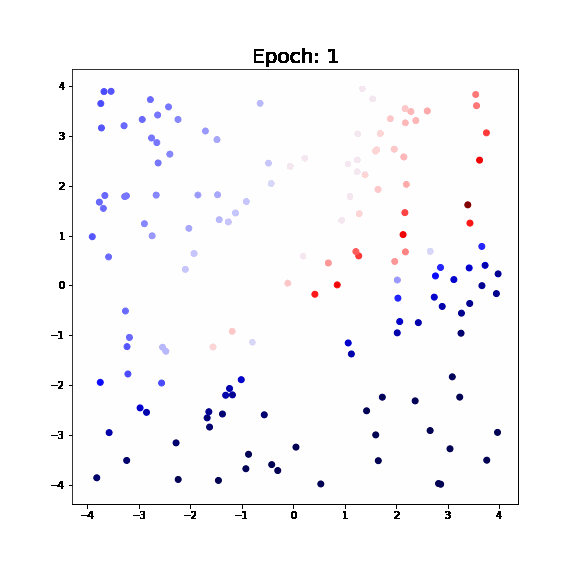

In [52]:
from IPython.display import Image
Image(filename="training_xor.gif")

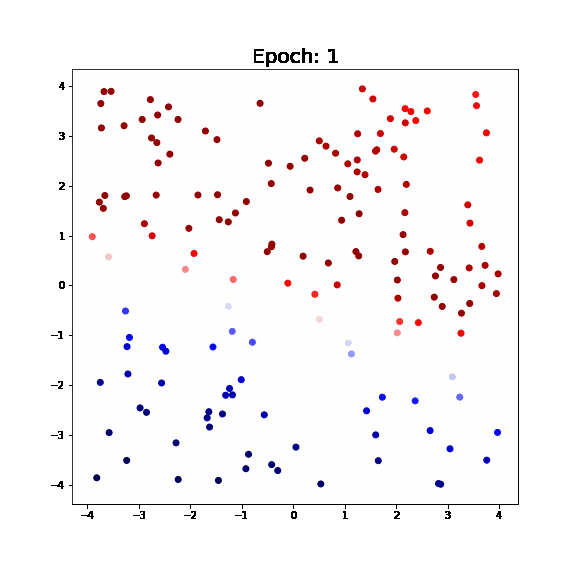

In [53]:
Image(filename="test_anim.gif")